# SDUP Pi
##### W ramach projektu zrealizowano obliczanie rozwinięcia dziesiętnego liczby Pi metodą Leibnitza, używając dwóch algorytmów dzielących (non-restoting i Newton Raphson), dodatkowo umożliwiając zrównoleglenie sprzętowe obliczeń aby móc odnieść się do prawa Amdahl'a

Autorzy:

Jakub Kłoczko  
Aleksandra Gaweł


## Wstęp teoretyczny

---

### Wyznaczanie liczby π metodą szeregów Leibniza

Szereg Leibniza to nieskończony szereg służący do przybliżenia liczby π:

$$\frac{\pi}{4} = 1 - \frac{1}{3} + \frac{1}{5} - \frac{1}{7} + \cdots$$

Przybliżenie liczby π uzyskujemy poprzez:

$$\pi \approx 4 \cdot \left(1 - \frac{1}{3} + \frac{1}{5} - \cdots + \frac{(-1)^n}{2n+1} \right)$$

*Zalety:*
- Bardzo prosta implementacja.
- Przejrzysta struktura matematyczna.

*Wady:*
- Bardzo powolna zbieżność — potrzeba tysięcy iteracji, aby uzyskać dokładność do kilku miejsc po przecinku.

---

### Dzielenie metodą non-restoring (dzielenie bez przywracania)

Non-restoring division to metoda binarnego dzielenia stosowana w systemach cyfrowych.

#### Idea:
- Rejestr A = 0 (reszta), Q = dzielna, M = dzielnik.
- W każdej iteracji:
  - Przesuwanie A i Q w lewo.
  - Odejmowanie (lub dodawanie) M od A.
  - Ustawienie bitu w Q na podstawie znaku A.
  - (Opcjonalnie) korekta reszty, jeśli końcowe A < 0.

*Zalety:*
- Nie wymaga cofania (restore) poprzednich wartości — szybsze działanie.
- Nadaje się do implementacji w sprzęcie.

*Wady:*
- Złożona logika operacji bitowych.
- Wymaga znajomości arytmetyki binarnej i reprezentacji liczb ze znakiem.

---

### Metoda Newtona-Raphsona dla odwrotności

Metoda Newtona-Raphsona może być użyta do wyznaczania odwrotności liczby $\frac{1}{D}$ przez rozwiązanie równania:

$$f(x) = 1 - Dx$$

#### Iteracyjny wzór:
$$x_{n+1} = x_n(2 - D x_n)$$

- $x_n$ to aktualne przybliżenie odwrotności.
- $D$ to liczba, której odwrotność obliczamy.

*Zalety:*
- Szybka konwergencja — przybliżenia bardzo szybko zbliżają się do dokładnego wyniku.
- Nadaje się do obliczeń zmiennoprzecinkowych i procesorów SIMD/GPU.

*Wady:*
- Wymaga dobrego przybliżenia początkowego (np. z tablic LUT).
- Wrażliwa na błędy zaokrągleń przy dużych liczbach lub ekstremalnych wartościach.

---

### Schematy blokowe wybranych modułów

#### pi_leibnitz - moduł TOP


![Działanie modułu sterującego](img/pi_leibnitz_TOP.png)


#### 1/x z wykorzystaniem z wykorzystaniem Newton Raphson 


![Działanie modułu sterującego](img/reciprocal_32bit.png)



## Implementacja

### Model w pythonie


In [21]:
import time 

def leibniz_pi(n_terms):
    return sum(4.0 * ((-1)**i) / (2*i + 1) for i in range(n_terms))


ITERS = 100_000

start_time = time.perf_counter()
approximation_pi = leibniz_pi(ITERS)
end_time = time.perf_counter()

execution_time_seconds = end_time - start_time

print(f"Obliczona wartość pi: {approximation_pi:.10f}")
print(f"Czas wykonania: {execution_time_seconds:.6f} s")


Obliczona wartość pi: 3.1415826536
Czas wykonania: 0.301009 s


### Model FPGA - Kria KV260

Test: pi_leibnitz_nr_1u.xsa
Czas: 0.173398 s
Pi: 3.1415826976
-------------------------
Test: pi_leibnitz_nr_10u.xsa
Czas: 0.019918 s
Pi: 3.1415826976
-------------------------
Test: pi_leibnitz_nr_100u.xsa
Czas: 0.002962 s
Pi: 3.1415826976
-------------------------
Test: kv260_pi_1u_non_restoring.xsa
Czas: 0.038073 s
Pi: 3.1415822320
-------------------------
Test: kv260_pi_10u_non_restoring.xsa
Czas: 0.004763 s
Pi: 3.1415822320
-------------------------
Test: kv260_pi_100u_non_restoring.xsa
Czas: 0.001413 s
Pi: 3.1415822320
-------------------------


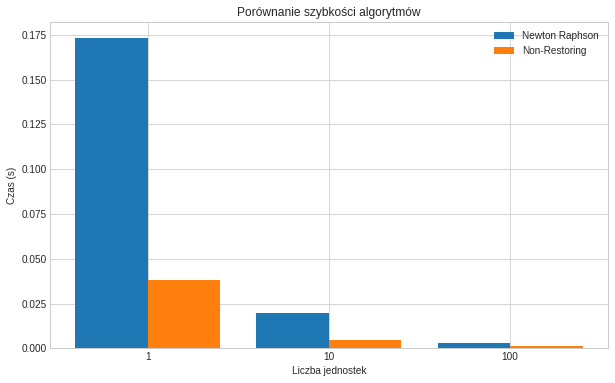

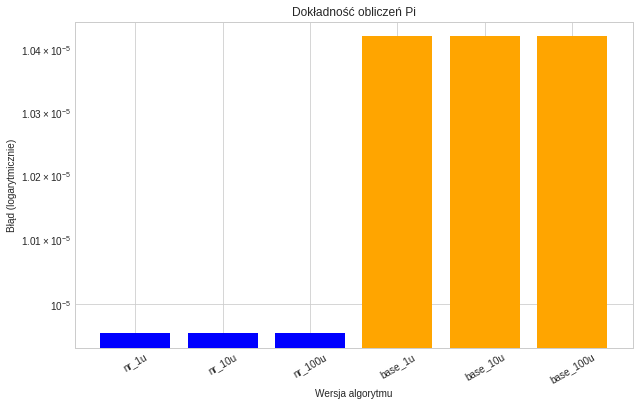

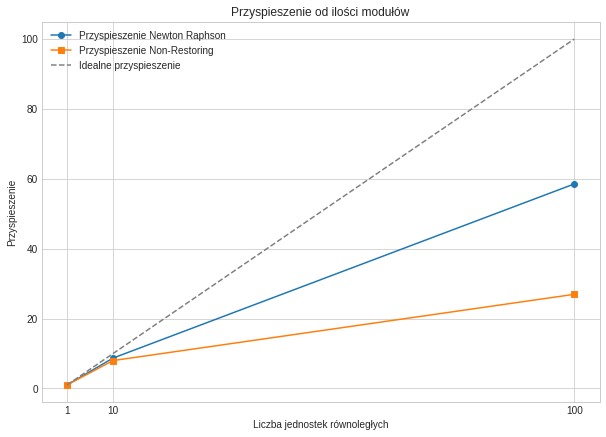

In [ ]:
import pynq
from pynq import Overlay
import time
import numpy as np
import matplotlib.pyplot as plt

filenames = [
    "pi_leibnitz_nr_1u.xsa",
    "pi_leibnitz_nr_10u.xsa",
    "pi_leibnitz_nr_100u.xsa",
    "kv260_pi_1u_non_restoring.xsa",
    "kv260_pi_10u_non_restoring.xsa",
    "kv260_pi_100u_non_restoring.xsa"
]
names = [
    "nr_1u",
    "nr_10u",
    "nr_100u",
    "base_1u",
    "base_10u",
    "base_100u"
]
ips = [
    "pi_leibnitz_nr_u1_0",
    "pi_leibnitz_nr_u1_0",
    "pi_leibnitz_nr_u1_0",
    "pi_leibnitz_0",
    "pi_leibnitz_0",
    "pi_leibnitz_0"
]

NUM_OF_ITERS = 100_000

czasy_wykonania = []
obliczone_pi = []
bledy = []

for i in range(len(filenames)):
    module = filenames[i]
    name = names[i]
    ip_name = ips[i]
    
    print("Test: " + module)
    
    ov = None
    
    try:
        ov = Overlay(module)
        ip_core = getattr(ov, ip_name)

        registers = ip_core.register_map
        
        registers.ITER_REG = NUM_OF_ITERS
        start_time = time.time()
        registers.CONTROL_REG = 1
        
        while not (int(registers.DONE_REG) & 0x00000001):
            pass
            
        end_time = time.time()
        
        execution_time = end_time - start_time
        result = int(registers.RESULT_REG) & 0xFFFFFFFF
        
        if (ip_name == "pi_leibnitz_0"):
            pi_val = result / (2**30)
        else:
            pi_val = result / (2**29)
            
        czasy_wykonania.append(execution_time)
        obliczone_pi.append(pi_val)
        bledy.append(abs(pi_val - np.pi))
        
        print(f"Czas: {execution_time:.6f} s")
        print(f"Pi: {pi_val:.10f}")

    except Exception as e:
        print("Błąd" + module)
        print(e)
        czasy_wykonania.append(0)
        obliczone_pi.append(0)
        bledy.append(0)
        
    finally:
        if ov:
            ov.free()
            
    print("-------------------------")

if len(czasy_wykonania) > 0 and sum(czasy_wykonania) > 0:

    czasy_nr = czasy_wykonania[0:3]
    czasy_base = czasy_wykonania[3:6]
    
    etykiety_x = ['1', '10', '100']
    x = np.arange(len(etykiety_x))
    
    plt.figure(figsize=(10, 6)) 
    plt.bar(x - 0.2, czasy_nr, 0.4, label='Newton Raphson')
    plt.bar(x + 0.2, czasy_base, 0.4, label='Non-Restoring')
    
    plt.ylabel('Czas (s)')
    plt.xlabel('Liczba jednostek')
    plt.title('Porównanie szybkości algorytmów')
    plt.xticks(x, etykiety_x)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    kolory = ['blue', 'blue', 'blue', 'orange', 'orange', 'orange']
    plt.bar(names, bledy, color=kolory)
    
    plt.ylabel('Błąd (logarytmicznie)')
    plt.xlabel('Wersja algorytmu')
    plt.title('Dokładność obliczeń Pi')
    plt.yscale('log')
    plt.xticks(rotation=30) 
    plt.show()

    czas_1_nr = czasy_nr[0]
    przyspieszenie_nr = [czas_1_nr / t for t in czasy_nr] if czas_1_nr > 0 else [0,0,0]
    
    czas_1_base = czasy_base[0]
    przyspieszenie_base = [czas_1_base / t for t in czasy_base] if czas_1_base > 0 else [0,0,0]

    liczba_jednostek = [1, 10, 100]
    
    plt.figure(figsize=(10, 7))
    plt.plot(liczba_jednostek, przyspieszenie_nr, 'o-', label='Przyspieszenie Newton Raphson')
    plt.plot(liczba_jednostek, przyspieszenie_base, 's-', label='Przyspieszenie Non-Restoring')
    plt.plot(liczba_jednostek, liczba_jednostek, '--', color='gray', label='Idealne przyspieszenie')
    
    plt.title('Przyspieszenie od ilości modułów')
    plt.xlabel('Liczba jednostek równoległych')
    plt.ylabel('Przyspieszenie')
    plt.xticks(liczba_jednostek)
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Błąd rysowania.")